In [1]:
import warnings
from collections import defaultdict
import itertools
from os.path import join as j
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.special import kl_div
#from scipy.stats import gaussian_kde, entropy, ttest_ind, ttest_rel
from scipy import stats
import seaborn as sns

# Load emb pairs

In [2]:
with open("../data_dirs.txt", "r") as f: # your dataset folder should  be in a text file here
    DATA_DIRS = f.readlines()
    DATA_DIRS = [p.strip() for p in DATA_DIRS]

In [3]:
PAIRS_PATH = j(DATA_DIRS[0], "derived", "aps_paper_pairs", "aps_all_2010_paper_pairs.gz")
df = pd.read_csv(PAIRS_PATH, header=0, dtype={"DOI_X": "str", "PACS_CODE_1_X": "int", "PACS_CODE_2_X": "str", "DOI_Y": "str", "PACS_CODE_1_Y": "int", "PACS_CODE_2_Y": "str"})

In [4]:
df

,DOI_X,PACS_CODE_1_X,PACS_CODE_2_X,DOI_Y,PACS_CODE_1_Y,PACS_CODE_2_Y
0,10.1103/PhysRevD.64.036003,1,11,10.1103/PhysRevC.70.064322,1,13
1,10.1103/PhysRevLett.102.035701,6,64,10.1103/PhysRevB.48.8667,6,61
2,10.1103/PhysRevB.46.12342,7,77,10.1103/PhysRevB.76.153307,7,72
3,10.1103/PhysRevD.50.7128,1,12,10.1103/PhysRevLett.77.5176,1,14
4,10.1103/PhysRevB.80.214409,7,73,10.1103/PhysRevB.64.134304,7,71
...,...,...,...,...,...,...
2156022,10.1103/PhysRevB.45.3870,7,72,10.1103/PhysRevLett.75.3822,4,42
2156023,10.1103/PhysRevB.56.9782,7,75,10.1103/PhysRevE.76.016218,0,05
2156024,10.1103/PhysRevB.51.6640,7,74,10.1103/PhysRevD.57.2101,9,95
2156025,10.1103/PhysRevLett.90.248303,3,33,10.1103/PhysRevC.32.1416,2,27


# Calculate cosine distances

In [5]:
# Helper for cosine distance
def cos_dist(u, v):
    return 1 - (
        np.einsum("ij,ij->i", u.values, v.values)
        / (np.linalg.norm(u.values, axis=1) * np.linalg.norm(v.values, axis=1))
    )

In [6]:
pair_df_doi = pd.concat([df.DOI_X, df.DOI_Y]).drop_duplicates().rename("DOI").to_frame()

In [7]:
EMB_PROPERTY = ["undirected"]*3 + ["title"]*3 + ["abstract"]*3
EMB_METHOD = ["leigenmap", "node2vec", "residual2vec", "doc2vec", "scibert", "sentencebert", "doc2vec", "scibert", "sentencebert"]

In [8]:
same_2 = {}
same_1 = {}
diff = {}
rand = {}

In [9]:
for i in range(0, len(EMB_METHOD)):
    PROPERTY = EMB_PROPERTY[i]
    EMBEDDING_METHOD = EMB_METHOD[i]
    EMBEDDING_PATH = j(DATA_DIRS[1], "embedding", "vectors", "aps_all_2010_{}_{}_vector.gz".format(PROPERTY, EMBEDDING_METHOD))
    
    vector = pd.read_csv(EMBEDDING_PATH, header=0).drop_duplicates("DOI").set_index("DOI") # why do SOME (abstract??) vectors have duplicate indices????
    DIM = vector.shape[1]
    vector.columns = list(range(0, DIM))
    
    # why do some sampled pairs have no embedding?
    vector = vector.merge(pair_df_doi, left_index=True, right_on="DOI").set_index("DOI")
    pair_df = df[(df.DOI_X.isin(vector.index)) & (df.DOI_Y.isin(vector.index))]
    
    # Split, sample
    same_2[(PROPERTY, EMBEDDING_METHOD)] = pair_df[pair_df.PACS_CODE_2_X == pair_df.PACS_CODE_2_Y]  # Same PACS level 2
    same_1[(PROPERTY, EMBEDDING_METHOD)] = pair_df[pair_df.PACS_CODE_1_X == pair_df.PACS_CODE_1_Y].sample(
        n=len(same_2[(PROPERTY, EMBEDDING_METHOD)])
    )  # Same PACS level 1
    diff[(PROPERTY, EMBEDDING_METHOD)] = pair_df[pair_df.PACS_CODE_1_X != pair_df.PACS_CODE_1_Y].sample(n=len(same_2[(PROPERTY, EMBEDDING_METHOD)]))  # Different PACS
    rand[(PROPERTY, EMBEDDING_METHOD)] = pair_df.sample(n=100000)#(n=len(same_2[(PROPERTY, EMBEDDING_METHOD)]))  # random

    # Calculate cosine distance
    same_2[(PROPERTY, EMBEDDING_METHOD)]["COS_DIST"] = cos_dist(vector.loc[same_2[(PROPERTY, EMBEDDING_METHOD)].DOI_X], vector.loc[same_2[(PROPERTY, EMBEDDING_METHOD)].DOI_Y])
    same_1[(PROPERTY, EMBEDDING_METHOD)]["COS_DIST"] = cos_dist(vector.loc[same_1[(PROPERTY, EMBEDDING_METHOD)].DOI_X], vector.loc[same_1[(PROPERTY, EMBEDDING_METHOD)].DOI_Y])
    diff[(PROPERTY, EMBEDDING_METHOD)]["COS_DIST"] = cos_dist(vector.loc[diff[(PROPERTY, EMBEDDING_METHOD)].DOI_X], vector.loc[diff[(PROPERTY, EMBEDDING_METHOD)].DOI_Y])
    rand[(PROPERTY, EMBEDDING_METHOD)]["COS_DIST"] = cos_dist(vector.loc[rand[(PROPERTY, EMBEDDING_METHOD)].DOI_X], vector.loc[rand[(PROPERTY, EMBEDDING_METHOD)].DOI_Y])

<ipython-input-9-f738b8a74154>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_2[(PROPERTY, EMBEDDING_METHOD)]["COS_DIST"] = cos_dist(vector.loc[same_2[(PROPERTY, EMBEDDING_METHOD)].DOI_X], vector.loc[same_2[(PROPERTY, EMBEDDING_METHOD)].DOI_Y])
<ipython-input-9-f738b8a74154>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_2[(PROPERTY, EMBEDDING_METHOD)]["COS_DIST"] = cos_dist(vector.loc[same_2[(PROPERTY, EMBEDDING_METHOD)].DOI_X], vector.loc[same_2[(PROPERTY, EMBEDDING_METHOD)].DOI_Y])
<ipyth

# Normality tests

In [10]:
for pe, df in rand.items():
    print(pe, stats.normaltest(df.COS_DIST))

('undirected', 'leigenmap') NormaltestResult(statistic=1304.8300886597544, pvalue=4.56821291066226e-284)
('undirected', 'node2vec') NormaltestResult(statistic=13098.964590362575, pvalue=0.0)
('undirected', 'residual2vec') NormaltestResult(statistic=31394.50098421373, pvalue=0.0)
('title', 'doc2vec') NormaltestResult(statistic=17162.69339413774, pvalue=0.0)
('title', 'scibert') NormaltestResult(statistic=32868.87389293629, pvalue=0.0)
('title', 'sentencebert') NormaltestResult(statistic=63.07613882017565, pvalue=2.0099742113786774e-14)
('abstract', 'doc2vec') NormaltestResult(statistic=1394.5039928627057, pvalue=1.539236856452484e-303)
('abstract', 'scibert') NormaltestResult(statistic=56737.847179446755, pvalue=0.0)
('abstract', 'sentencebert') NormaltestResult(statistic=78.9576416038001, pvalue=7.154280665195e-18)


In [11]:
for pe, df in diff.items():
    print(pe, stats.normaltest(df.COS_DIST))

('undirected', 'leigenmap') NormaltestResult(statistic=641.7522656440182, pvalue=4.418411300304175e-140)
('undirected', 'node2vec') NormaltestResult(statistic=7659.25824578241, pvalue=0.0)
('undirected', 'residual2vec') NormaltestResult(statistic=18855.776471022396, pvalue=0.0)
('title', 'doc2vec') NormaltestResult(statistic=11551.172408057188, pvalue=0.0)
('title', 'scibert') NormaltestResult(statistic=20458.89340562107, pvalue=0.0)
('title', 'sentencebert') NormaltestResult(statistic=1.990200473161959, pvalue=0.36968638658738234)
('abstract', 'doc2vec') NormaltestResult(statistic=212.80014774538282, pvalue=6.180662695664152e-47)
('abstract', 'scibert') NormaltestResult(statistic=8773.757786792745, pvalue=0.0)
('abstract', 'sentencebert') NormaltestResult(statistic=42.24324628386688, pvalue=6.714220823393108e-10)


In [12]:
for pe, df in same_1.items():
    print(pe, stats.normaltest(df.COS_DIST))

('undirected', 'leigenmap') NormaltestResult(statistic=3330.5458511934257, pvalue=0.0)
('undirected', 'node2vec') NormaltestResult(statistic=4583.897262492063, pvalue=0.0)
('undirected', 'residual2vec') NormaltestResult(statistic=10208.145450183556, pvalue=0.0)
('title', 'doc2vec') NormaltestResult(statistic=10689.066538807736, pvalue=0.0)
('title', 'scibert') NormaltestResult(statistic=19163.839115297586, pvalue=0.0)
('title', 'sentencebert') NormaltestResult(statistic=201.633341169717, pvalue=1.643903352484618e-44)
('abstract', 'doc2vec') NormaltestResult(statistic=193.71266431644693, pvalue=8.626396307338885e-43)
('abstract', 'scibert') NormaltestResult(statistic=8840.088717835948, pvalue=0.0)
('abstract', 'sentencebert') NormaltestResult(statistic=23.631516706088455, pvalue=7.387225354017989e-06)


In [13]:
for pe, df in same_2.items():
    print(pe, stats.normaltest(df.COS_DIST))

('undirected', 'leigenmap') NormaltestResult(statistic=9499.182178354622, pvalue=0.0)
('undirected', 'node2vec') NormaltestResult(statistic=2277.6648048061134, pvalue=0.0)
('undirected', 'residual2vec') NormaltestResult(statistic=4970.173375243499, pvalue=0.0)
('title', 'doc2vec') NormaltestResult(statistic=10957.849861593175, pvalue=0.0)
('title', 'scibert') NormaltestResult(statistic=20745.624867050716, pvalue=0.0)
('title', 'sentencebert') NormaltestResult(statistic=346.3489905657568, pvalue=6.184040031535869e-76)
('abstract', 'doc2vec') NormaltestResult(statistic=273.8010855027911, pvalue=3.5063051816505327e-60)
('abstract', 'scibert') NormaltestResult(statistic=8979.823873664205, pvalue=0.0)
('abstract', 'sentencebert') NormaltestResult(statistic=15.875682937433961, pvalue=0.0003569761915598843)


# Calculate KL divergence, Jensen-Shannon distance

In [14]:
rand_sample = {k:v.sample(n=len(same_2[k])) for k,v in rand.items()}

In [15]:
idx = ["rand", "diff", "same_1", "same_2"]

In [16]:
attr_dict = {"rand":rand_sample, "diff":diff, "same_1": same_1, "same_2":same_2}

In [17]:
js_dist = {}
kl_divs = {}

In [18]:
for k in same_2.keys():
    js_dist[k] = pd.DataFrame(data=np.zeros((4,4)), index=idx, columns=idx)
    kl_divs[k] = pd.DataFrame(data=np.zeros((4,4)), index=idx, columns=idx)
    for pair in itertools.permutations(idx, 2):
        pdf_a = attr_dict[pair[0]][k].COS_DIST
        pdf_b = attr_dict[pair[1]][k].COS_DIST
        js_dist[k].loc[pair] = distance.jensenshannon(pdf_a, pdf_b)
        kl_divs[k].loc[pair] = stats.entropy(pdf_a, pdf_b)

In [19]:
js_dist

{('undirected',
  'leigenmap'):             rand      diff    same_1    same_2
 rand    0.000000  0.045178  0.046323  0.048234
 diff    0.045178  0.000000  0.046081  0.047805
 same_1  0.046323  0.046081  0.000000  0.049172
 same_2  0.048234  0.047805  0.049172  0.000000,
 ('undirected',
  'node2vec'):             rand      diff    same_1    same_2
 rand    0.000000  0.088165  0.107963  0.120338
 diff    0.088165  0.000000  0.104126  0.116655
 same_1  0.107963  0.104126  0.000000  0.132816
 same_2  0.120338  0.116655  0.132816  0.000000,
 ('undirected',
  'residual2vec'):             rand      diff    same_1    same_2
 rand    0.000000  0.092071  0.125233  0.147540
 diff    0.092071  0.000000  0.119760  0.143269
 same_1  0.125233  0.119760  0.000000  0.166060
 same_2  0.147540  0.143269  0.166060  0.000000,
 ('title',
  'doc2vec'):             rand      diff    same_1    same_2
 rand    0.000000  0.202803  0.201228  0.200567
 diff    0.202803  0.000000  0.201037  0.202061
 same_1  0.201

In [20]:
ttest = {}
for k in same_2.keys():
    ttest_diff = dict(zip(["T", "p-value"], stats.ttest_1samp(diff[k].COS_DIST, np.mean(rand[k].COS_DIST), alternative="two-sided")))
    ttest_same1 = dict(zip(["T", "p-value"], stats.ttest_1samp(same_1[k].COS_DIST, np.mean(diff[k].COS_DIST), alternative="less")))
    ttest_same2 = dict(zip(["T", "p-value"], stats.ttest_1samp(same_2[k].COS_DIST, np.mean(same_1[k].COS_DIST), alternative="less")))
    
    ttest[k] = pd.DataFrame({"\mu(Different PACS) \neq \mu(Random)": ttest_diff, "\mu(Same L1 PACS) < \mu(Random)": ttest_same1, "\mu(Same L2 PACS) < \mu(Same L1 PACS)": ttest_same2}).T

In [21]:
ttest = pd.concat(ttest.values(), keys=ttest.keys())
#wilrank = pd.concat(wilrank.values(), keys=wilrank.keys())

In [22]:
#pd.concat([ttest, wilrank], axis=1)
ttest

T  \
undirected leigenmap    \mu(Different PACS) \neq \mu(Random)     3.385112   
                        \mu(Same L1 PACS) < \mu(Random)        -15.310420   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   -9.792899   
           node2vec     \mu(Different PACS) \neq \mu(Random)    34.187575   
                        \mu(Same L1 PACS) < \mu(Random)       -173.571120   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)  -88.511888   
           residual2vec \mu(Different PACS) \neq \mu(Random)    35.306278   
                        \mu(Same L1 PACS) < \mu(Random)       -143.232650   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)  -82.218479   
title      doc2vec      \mu(Different PACS) \neq \mu(Random)    -1.130630   
                        \mu(Same L1 PACS) < \mu(Random)        -12.140242   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   -3.278644   
           scibert      \mu(Different PACS) \neq \mu(Random)     0.021896   
                        \mu(Same L1 PACS) < \mu(Random)          4.742644   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)  -10.216087   
           sentencebert \mu(Different PACS) \neq \mu(Random)    18.091929   
                        \mu(Same L1 PACS) < \mu(Random)       -104.797470   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)  -32.841560   
abstract   doc2vec      \mu(Different PACS) \neq \mu(Random)     2.106944   
                        \mu(Same L1 PACS) < \mu(Random)         -9.287962   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   -9.985976   
           scibert      \mu(Different PACS) \neq \mu(Random)    -0.238185   
                        \mu(Same L1 PACS) < \mu(Random)         -1.983804   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   -0.272244   
           sentencebert \mu(Different PACS) \neq \mu(Random)     9.305857   
                        \mu(Same L1 PACS) < \mu(Random)        -65.079754   
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)  -17.343488   

                                                                     p-value  
undirected leigenmap    \mu(Different PACS) \neq \mu(Random)    7.119327e-04  
                        \mu(Same L1 PACS) < \mu(Random)         4.068434e-53  
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   6.271338e-23  
           node2vec     \mu(Different PACS) \neq \mu(Random)   8.508270e-254  
                        \mu(Same L1 PACS) < \mu(Random)         0.000000e+00  
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   0.000000e+00  
           residual2vec \mu(Different PACS) \neq \mu(Random)   2.271689e-270  
                        \mu(Same L1 PACS) < \mu(Random)         0.000000e+00  
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   0.000000e+00  
title      doc2vec      \mu(Different PACS) \neq \mu(Random)    2.582148e-01  
                        \mu(Same L1 PACS) < \mu(Random)         3.511958e-34  
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   5.218056e-04  
           scibert      \mu(Different PACS) \neq \mu(Random)    9.825309e-01  
                        \mu(Same L1 PACS) < \mu(Random)         9.999989e-01  
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   8.781972e-25  
           sentencebert \mu(Different PACS) \neq \mu(Random)    5.680513e-73  
                        \mu(Same L1 PACS) < \mu(Random)         0.000000e+00  
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)  7.699278e-235  
abstract   doc2vec      \mu(Different PACS) \neq \mu(Random)    3.513877e-02  
                        \mu(Same L1 PACS) < \mu(Random)         8.907250e-21  
                        \mu(Same L2 PACS) < \mu(Same L1 PACS)   1.036264e-23  
           scibert      \mu(Different PACS) \neq \mu(Random)    8.117408e-01  
                        \mu(Same L1 PACS) < \mu(Random)         2.364781e-02  
                   

# get means and standard errors of each dist

In [23]:
# helper function
# from here https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [24]:
mean_conf_int = {}

In [25]:
attr_dict.keys()

dict_keys(['rand', 'diff', 'same_1', 'same_2'])

In [26]:
for k in same_2.keys():
    mean_conf_int[k] = [mean_ci(attr_dict[attr][k].COS_DIST, 0.95) for attr in attr_dict.keys()]
    mean_conf_int[k] = pd.DataFrame(mean_conf_int[k], index=attr_dict.keys(), columns=["m-h","m","m+h"])

In [27]:
mean_conf_int = pd.concat(mean_conf_int.values(), keys=mean_conf_int.keys())

In [28]:
mean_conf_int

m-h         m       m+h
undirected leigenmap    rand    0.998208  0.997500  0.998917
                        diff    0.999250  0.998548  0.999952
                        same_1  0.993563  0.992834  0.994291
                        same_2  0.989739  0.988974  0.990504
           node2vec     rand    0.703926  0.702962  0.704891
                        diff    0.719243  0.718357  0.720129
                        same_1  0.621097  0.619989  0.622205
                        same_2  0.567483  0.566296  0.568671
           residual2vec rand    0.992110  0.990725  0.993496
                        diff    1.013943  1.012723  1.015164
                        same_1  0.882716  0.880921  0.884512
                        same_2  0.797595  0.795566  0.799625
title      doc2vec      rand    0.525637  0.523933  0.527341
                        diff    0.525192  0.523483  0.526902
                        same_1  0.515052  0.513415  0.516689
                        same_2  0.512313  0.510676  0.513951
           scibert      rand    0.101306  0.100570  0.102041
                        diff    0.101542  0.100807  0.102278
                        same_1  0.103393  0.102628  0.104158
                        same_2  0.099523  0.098780  0.100265
           sentencebert rand    0.733458  0.732597  0.734320
                        diff    0.741287  0.740440  0.742134
                        same_1  0.694601  0.693728  0.695474
                        same_2  0.679320  0.678408  0.680232
abstract   doc2vec      rand    0.654187  0.651381  0.656993
                        diff    0.658281  0.655466  0.661095
                        same_1  0.644968  0.642158  0.647777
                        same_2  0.630270  0.627385  0.633155
           scibert      rand    0.085972  0.083748  0.088196
                        diff    0.084467  0.082266  0.086669
                        same_1  0.082231  0.080022  0.084441
                        same_2  0.081927  0.079740  0.084115
           sentencebert rand    0.658475  0.656885  0.660065
                        diff    0.667093  0.665538  0.668649
                        same_1  0.614283  0.612692  0.615873
                        same_2  0.600168  0.598573  0.601763

# visualizations

In [29]:
# For prettification of figure
prop_stylized = {
    "undirected": "Undirected Graph",
    "tocited": "Directed (to reference) Graph",
    "tociting": "Directed (to citing paper) Graph",
    "title": "Title",
    "abstract": "Abstract",
    "titleabstract": "Title+Abstract",
    "fulltext": "Full Text",
}
emb_stylized = {
    "leigenmap": "Laplacian Eigenmap",
    "node2vec": "node2vec",
    "residual2vec": "residual2vec",
    "doc2vec": "doc2vec",
    "scibert": "SciBERT",
    "sentencebert": "Sentence-BERT",
}

In [34]:
# table
ttest_disp = ttest.copy()
ttest_disp = ttest_disp.reset_index().rename(columns={"level_0":"Property", "level_1":"Embedding method", "level_2":"H_a"})
ttest_disp["Property"] = ttest_disp["Property"].map(prop_stylized)
ttest_disp["Embedding method"] = ttest_disp["Embedding method"].map(emb_stylized)
ttest_disp = ttest_disp.set_index(["Property", "Embedding method", "H_a"])
ttest_disp["T"] = ttest_disp["T"].map('{:,.4f}'.format)
ttest_disp["p-value"] = ttest_disp["p-value"].map('{:,.4f}'.format)

In [35]:
ttest_disp

T  \
Property         Embedding method   H_a                                                
Undirected Graph Laplacian Eigenmap \mu(Different PACS) \neq \mu(Random)      3.3851   
                                    \mu(Same L1 PACS) < \mu(Random)         -15.3104   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)    -9.7929   
                 node2vec           \mu(Different PACS) \neq \mu(Random)     34.1876   
                                    \mu(Same L1 PACS) < \mu(Random)        -173.5711   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)   -88.5119   
                 residual2vec       \mu(Different PACS) \neq \mu(Random)     35.3063   
                                    \mu(Same L1 PACS) < \mu(Random)        -143.2327   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)   -82.2185   
Title            doc2vec            \mu(Different PACS) \neq \mu(Random)     -1.1306   
                                    \mu(Same L1 PACS) < \mu(Random)         -12.1402   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)    -3.2786   
                 SciBERT            \mu(Different PACS) \neq \mu(Random)      0.0219   
                                    \mu(Same L1 PACS) < \mu(Random)           4.7426   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)   -10.2161   
                 Sentence-BERT      \mu(Different PACS) \neq \mu(Random)     18.0919   
                                    \mu(Same L1 PACS) < \mu(Random)        -104.7975   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)   -32.8416   
Abstract         doc2vec            \mu(Different PACS) \neq \mu(Random)      2.1069   
                                    \mu(Same L1 PACS) < \mu(Random)          -9.2880   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)    -9.9860   
                 SciBERT            \mu(Different PACS) \neq \mu(Random)     -0.2382   
                                    \mu(Same L1 PACS) < \mu(Random)          -1.9838   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)    -0.2722   
                 Sentence-BERT      \mu(Different PACS) \neq \mu(Random)      9.3059   
                                    \mu(Same L1 PACS) < \mu(Random)         -65.0798   
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)   -17.3435   

                                                                          p-value  
Property         Embedding method   H_a                                            
Undirected Graph Laplacian Eigenmap \mu(Different PACS) \neq \mu(Random)   0.0007  
                                    \mu(Same L1 PACS) < \mu(Random)        0.0000  
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)  0.0000  
                 node2vec           \mu(Different PACS) \neq \mu(Random)   0.0000  
                                    \mu(Same L1 PACS) < \mu(Random)        0.0000  
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)  0.0000  
                 residual2vec       \mu(Different PACS) \neq \mu(Random)   0.0000  
                                    \mu(Same L1 PACS) < \mu(Random)        0.0000  
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)  0.0000  
Title            doc2vec            \mu(Different PACS) \neq \mu(Random)   0.2582  
                                    \mu(Same L1 PACS) < \mu(Random)        0.0000  
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)  0.0005  
                 SciBERT            \mu(Different PACS) \neq \mu(Random)   0.9825  
                                    \mu(Same L1 PACS) < \mu(Random)        1.0000  
                                    \mu(Same L2 PACS) < \mu(Same L1 PACS)  0.0000  
                 Sentence-BERT      \mu(Different PACS) \neq \mu(Random)   0.0000  
                  

In [37]:
with open("aps_all_2010_emb_distance_ttest.tex", "w") as f:
    ttest_disp.to_latex(f)

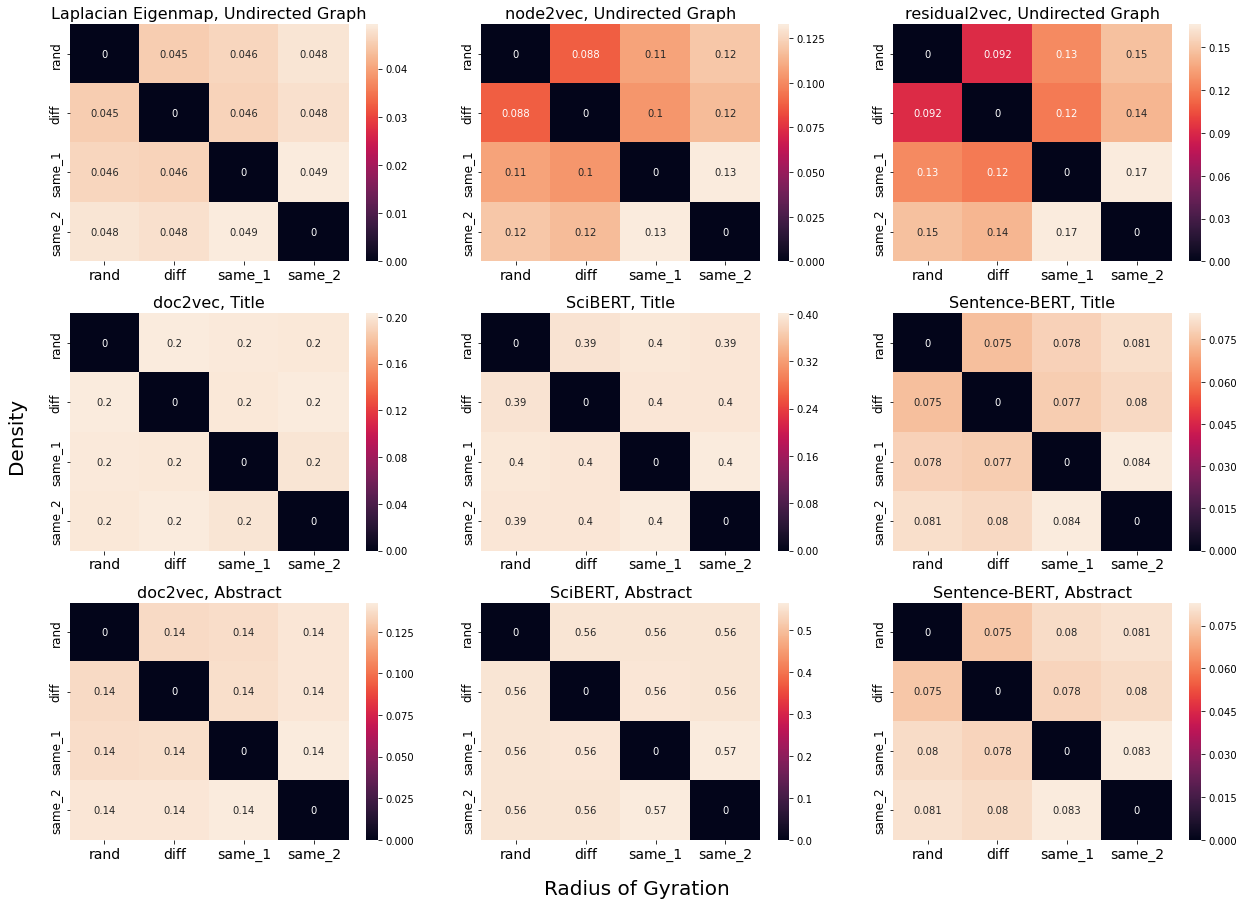

In [36]:
# heatmap
fig = plt.figure(figsize=(21,15))
fig.text(0.5, 0.08, 'Radius of Gyration', ha='center', va='center', fontsize=20)
fig.text(0.09, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20)
for i in range(len(js_dist)):
    pe = list(js_dist.keys())[i]
    df = list(js_dist.values())[i]
    PROPERTY = pe[0]
    EMBEDDING_METHOD = pe[1]
    
    try:
        st_prop = prop_stylized[PROPERTY]
    except KeyError:
        st_prop = PROPERTY
    try:
        st_emb = emb_stylized[EMBEDDING_METHOD]
    except KeyError:
        st_emb = EMBEDDING_METHOD
    
    ax = fig.add_subplot(3,3,i+1)
    
    # Plot ROG
    sns.heatmap(df, ax=ax, annot=True)
    #g = sns.kdeplot(rand[i]["COS_DIST"], label="Random", color="gray", ax=ax)
    #g.set(xlabel=None, ylabel=None)
    #if i%3 != 1:
    #    g.set(yticklabels=[])
    #if i < 7:
    #    g.set(xticklabels=[])
    
    #ax.axis(xmin=0,xmax=2, ymin=0, ymax=5)
    ax.set_title("{}, {}".format(st_emb, st_prop)) 
    ax.title.set_size(16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
#    if i==len(EMB_METHOD)-1:
#        ax.legend(fontsize=14, loc="lower right")
#    else:
#        ax.get_legend().remove()
    
    # Prettify
    ax.set_title("{}, {}".format(st_emb, st_prop))  #("{} {} Embedding Cosine Distance".format(st_prop, st_emb))
    ax.set(xlabel=None, ylabel=None)
    ax.title.set_size(16)
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.tick_params(axis='x', which='major', labelsize=14)
    plt.setp(ax.get_yticklabels(), va="center")

plt.subplots_adjust(wspace=0.18, hspace=0.22)

plt.savefig(
    "aps_all_2010_emb_distance_dist_js.pdf",
    bbox_inches="tight",
)

In [ ]:
mean_conf_int

In [ ]:
mean_conf_int["mean"] - mean_conf_int["ci_95"]